## Step 0: Preparation

In [ ]:
!pip install -qqq flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/

In [ ]:
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.1 / PyTorch 2.5.1+cu121


#### Load dataset and preprocessing

In [ ]:
# Khi chạy bằng colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
train_4 = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_4 = pd.read_csv(train_4, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# remaining_rul = max_rul - cycle
max_cycle = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

In [ ]:
# train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_4.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [ ]:
# Normalization
df = train_4.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.993111,0.550773,0.400540,0.0,0.288660,0.627907,1.0,0.015473,0.015881,0.590406
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.992395,0.481761,0.351346,0.0,0.608247,0.864693,1.0,0.477968,0.481487,0.588561
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.993056,0.531031,0.423787,0.0,0.278351,0.627907,1.0,0.010764,0.018932,0.586716
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.993194,0.553707,0.401716,0.0,0.268041,0.627907,1.0,0.012782,0.018724,0.584871
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.001405,0.048140,0.920536,0.0,0.030928,0.000000,0.0,0.130172,0.145560,0.583026


In [ ]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class FD004DatasetLoader(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [ ]:
dataset = FD004DatasetLoader(df)
train_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=42)

num_clients = 10
subsets_train = split_dataset(train_data, num_clients)
subsets_validation = split_dataset(validation_data, num_clients)
# Tạo DataLoader cho mỗi tập
client_loader_trains = [DataLoader(subset, batch_size=128, shuffle=True) for subset in subsets_train]
client_loader_validations = [DataLoader(subset, batch_size=128, shuffle=True) for subset in subsets_validation]

# train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [ ]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 4322 samples
Client 2 will use a subset with 4322 samples
Client 3 will use a subset with 4322 samples
Client 4 will use a subset with 4322 samples
Client 5 will use a subset with 4322 samples
Client 6 will use a subset with 4322 samples
Client 7 will use a subset with 4322 samples
Client 8 will use a subset with 4322 samples
Client 9 will use a subset with 4322 samples
Client 10 will use a subset with 4324 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i, loader in enumerate(client_loader_validations):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 1080 samples
Client 2 will use a subset with 1080 samples
Client 3 will use a subset with 1080 samples
Client 4 will use a subset with 1080 samples
Client 5 will use a subset with 1080 samples
Client 6 will use a subset with 1080 samples
Client 7 will use a subset with 1080 samples
Client 8 will use a subset with 1080 samples
Client 9 will use a subset with 1080 samples
Client 10 will use a subset with 1086 samples


## Step 1: Centralized Training with PyTorch

#### Define the Transformer model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)

#### Define train function the model

In [ ]:
def train(model, client_loader_train, client_loader_validation: None, epochs: int, verbose=False):
    input_dim = 24
    model = model.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(client_loader_train)}, Val Loss = {val_loss / len(client_loader_validation)}")

In [ ]:
def predict_on_batch(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    # Lấy một vài mẫu dữ liệu từ tập val_loader
    samples, targets = next(iter(client_loader_validation))  # Lấy một batch từ validation set
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(samples)  # [batch_size]
    val_loss = criterion(predictions, targets)

    if return_actual_rul:
        # Đưa kết quả về CPU để xử lý
        samples = samples.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # Đảo chuẩn hóa dữ liệu
        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        # Đưa predictions và targets về dạng thực tế
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            # Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return val_loss, actual_predictions, actual_targets

    return val_loss


In [ ]:
def test(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    accuracys = 0
    with torch.no_grad():
      for batch in client_loader_validation:
        samples, targets = batch
        samples, targets = samples.to(DEVICE), targets.to(DEVICE)
        predictions = model(samples)
        val_loss += criterion(predictions, targets).item()
    return val_loss / len(client_loader_validation)


#### Train the model (Centralized Transformer model)

In [ ]:
model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(DEVICE)
train(model=model, client_loader_train=client_loader_trains[0], client_loader_validation=client_loader_validations[0], epochs=50)

Epoch 1: Train Loss = 0.0770935120389742, Val Loss = 0.02762496843934059
Epoch 2: Train Loss = 0.04592930930940544, Val Loss = 0.02401454353498088
Epoch 3: Train Loss = 0.04089770301738206, Val Loss = 0.023957566254668765
Epoch 4: Train Loss = 0.036765101694447154, Val Loss = 0.02367129921913147
Epoch 5: Train Loss = 0.0336604312829235, Val Loss = 0.02379715566833814
Epoch 6: Train Loss = 0.03164672090069336, Val Loss = 0.02442381117078993
Epoch 7: Train Loss = 0.0300770676420892, Val Loss = 0.02284394142528375
Epoch 8: Train Loss = 0.02890728068921496, Val Loss = 0.02294164699398809
Epoch 9: Train Loss = 0.028721100541160387, Val Loss = 0.02318852125770516
Epoch 10: Train Loss = 0.028352831819039935, Val Loss = 0.023127241267098322
Epoch 11: Train Loss = 0.02749636730946162, Val Loss = 0.022857874838842288
Epoch 12: Train Loss = 0.027179677313303247, Val Loss = 0.02268158385737075
Epoch 13: Train Loss = 0.026571640525670612, Val Loss = 0.023279290439354047
Epoch 14: Train Loss = 0.026

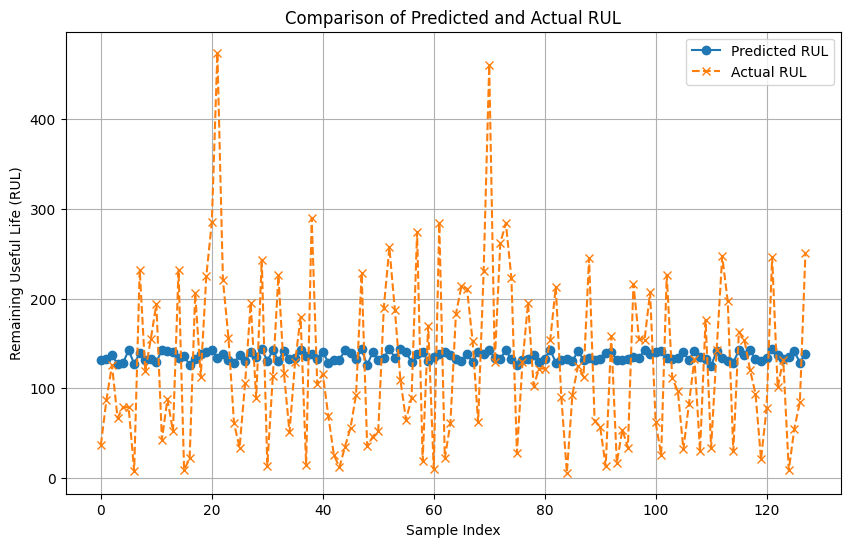

loss=0.027119962498545647
actual rul = [131.40971  132.46489  137.10876  127.21091  128.72997  142.25012
 127.62434  139.08646  131.75386  132.86687  129.75493  142.28336
 141.90547  140.41814  133.60922  135.80244  126.116165 133.11113
 138.2487   140.95047  142.37447  133.71393  137.96834  132.12741
 128.37454  137.14444  129.98822  140.9812   134.43758  144.02051
 130.63652  142.29033  130.67201  142.1079   132.62009  133.8948
 142.5203   135.64468  137.79005  133.23193  140.89995  128.6876
 131.33551  131.4275   142.74268  139.58943  132.82576  143.31898
 126.0155   140.25972  131.19386  133.7733   144.24516  133.90497
 143.53545  141.03203  128.82677  138.31966  140.78687  129.93503
 135.26166  138.0706   140.44655  137.09549  132.31511  130.36221
 137.9782   129.11922  140.71112  138.7387   143.08382  133.31018
 132.77496  142.61745  132.28598  125.93663  132.0443   132.78496
 137.41527  128.83873  132.60512  143.00119  128.77092  131.97044
 132.56113  130.19215  141.77884  131.7

In [ ]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[1], return_actual_rul=True, show_fig=True)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

In [ ]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[2], return_actual_rul=True, show_fig=False)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

loss=0.02467992715537548
actual rul = [132.40944  140.70946  142.63951  131.58115  139.4857   131.93016
 141.12302  136.8223   141.66687  127.76625  135.09563  143.17749
 136.10446  133.47432  123.993225 134.08444  137.05312  132.38237
 128.94107  131.67993  131.46362  132.40762  140.85144  129.25172
 136.53658  140.91034  132.75262  141.15047  138.94351  140.46613
 139.73128  131.36993  140.94691  132.75592  128.53229  128.55692
 137.2182   131.18524  141.5065   132.60732  138.05574  137.99042
 125.31618  143.47108  128.7099   133.7141   129.10724  142.30907
 133.0764   138.4806   134.22586  133.16336  142.19427  132.06197
 138.34488  141.45384  123.732956 133.09932  132.13478  130.58908
 131.57173  132.71013  132.71132  132.29555  136.72096  132.06181
 138.0072   140.63313  130.67253  133.84845  142.71056  135.00291
 140.84526  129.69913  130.81946  141.75137  133.2453   132.51181
 135.84398  127.85896  131.90813  132.05719  132.25258  133.63469
 131.15533  137.14314  132.9339   128.

## Step 2: Federated Learning with Flower

#### Update model parameters

In [ ]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)


def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

#### Define the Flower ClientApp

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train(model=self.model, client_loader_train=self.trainloader, client_loader_validation=self.valloader, epochs=1)
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1).to(device)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp

In [ ]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the training

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
# Run simulation
NUM_CLIENTS = 10
run_simulation(
  server_app=server,
  client_app=client,
  num_supernodes=NUM_CLIENTS,
  backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1669) 2024-12-01 15:34:09.579829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1669) 2024-12-01 15:34:09.705150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1669) 2024-12-01 15:34:09.721228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1669) 2024-12-01 15:34:11.550436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning

(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05580789562972153, Val Loss = 0.02322080669303735
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05916060835999601, Val Loss = 0.02309148468905025
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.06093914423357038, Val Loss = 0.028408231627609994
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05988206736305181, Val Loss = 0.025631373955143824
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05991693914813154, Val Loss = 0.026737205270263884
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05780725717982825, Val Loss = 0.023053636981381312
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.06235619820654392, Val Loss = 0.03081520853771104
(ClientAppActor pid=1669) Epoch 1: Train Loss = 0.05750609320752761, Val Loss = 0.025726178454028234


#### Where's the accuracy?

In [ ]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

#     # Aggregate and return custom metric (weighted average)
#     return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# def server_fn(context: Context) -> ServerAppComponents:
#     """Construct components that set the ServerApp behaviour.

#     You can use settings in `context.run_config` to parameterize the
#     construction of all elements (e.g the strategy or the number of rounds)
#     wrapped in the returned ServerAppComponents object.
#     """

#     # Create FedAvg strategy
#     strategy = FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     )

#     # Configure the server for 5 rounds of training
#     config = ServerConfig(num_rounds=5)

#     return ServerAppComponents(strategy=strategy, config=config)


# # Create a new server instance with the updated FedAvg strategy
# server = ServerApp(server_fn=server_fn)

# # Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )